In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statistics import mean, stdev
import matplotlib
from rlhfutils.data import load_wgpt, augment_data, load_apfarm, load_stack, load_rlcd
from dataclasses import dataclass
from transformers import AutoTokenizer
from collections import Counter

/u/prasanns/miniconda3/envs/rlhfenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
%load_ext autoreload
%autoreload 2

In [22]:
toker = AutoTokenizer.from_pretrained("../models/sft/")

# Custom aggregation function to collect values into a list and sort by index
def collect_and_sort(series):
    return list(series.sort_index())

def make_statdf(cdf):
    # Group by 'uid' and aggregate
    new_df = cdf.groupby('uid').agg({
        'rew_j': collect_and_sort,
        'rew_k': collect_and_sort
    }).reset_index()
    new_df['diffs'] = [[r['rew_j'][i] - r['rew_k'][i] for i in range(len(r['rew_j']))] for _, r in new_df.iterrows()]
    return new_df

def lenscat(idf):
    return plt.hist2d(idf['vars'], idf['confs'], bins=(50, 50), norm=matplotlib.colors.LogNorm())

def lenheur(idf):
    return  (idf['tj']>idf['tk']).mean()

def alltoks(col):
    atoks = []
    for c in col:
        atoks.extend(list(set(toker(c).input_ids)))
    return [toker.decode(d) for d in atoks]

def companalysis(indf, thresh):
    good = Counter(alltoks(indf['rj']))
    bad = Counter(alltoks(indf['rk']))

    total = good+bad
    total = {token: count for token, count in total.items() if count >= thresh}
    
    # Compute the conditional probability P(Class|Token) for each token and each class
    good_token_prob = {token: good.get(token, 0) / total[token] for token in total}
    bad_token_prob = {token: bad.get(token, 0) / total[token] for token in total}
    
    # Find top tokens for each class
    top_good_tokens = sorted(good_token_prob.items(), key=lambda x: x[1], reverse=True)[:5]
    top_bad_tokens = sorted(bad_token_prob.items(), key=lambda x: x[1], reverse=True)[:5]
    
    print("Top tokens with probabilities for 'good' class:")
    for token, prob in top_good_tokens:
        print(f"{token}: {prob:.4f}")
    
    print("Top tokens with probabilities for 'bad' class:")
    for token, prob in top_bad_tokens:
        print(f"{token}: {prob:.4f}")

def lenscat(idf):
    plt.hist2d(idf['vars'], idf['confs'], bins=(50, 50), norm=matplotlib.colors.LogNorm())

def lenheur(idf):
    return  (idf['tj']>idf['tk']).mean()

def alltoks(col):
    atoks = []
    for c in col:
        atoks.extend(list(set(toker(c).input_ids)))
    return [toker.decode(d) for d in atoks]

def companalysis(indf, thresh):
    good = Counter(alltoks(indf['rj']))
    bad = Counter(alltoks(indf['rk']))

    total = good+bad
    total = {token: count for token, count in total.items() if count >= thresh}
    
    # Compute the conditional probability P(Class|Token) for each token and each class
    good_token_prob = {token: good.get(token, 0) / total[token] for token in total}
    bad_token_prob = {token: bad.get(token, 0) / total[token] for token in total}
    
    # Find top tokens for each class
    top_good_tokens = sorted(good_token_prob.items(), key=lambda x: x[1], reverse=True)[:5]
    top_bad_tokens = sorted(bad_token_prob.items(), key=lambda x: x[1], reverse=True)[:5]
    
    print("Top tokens with probabilities for 'good' class:")
    for token, prob in top_good_tokens:
        print(f"{token}: {prob:.4f}")
    
    print("Top tokens with probabilities for 'bad' class:")
    for token, prob in top_bad_tokens:
        print(f"{token}: {prob:.4f}")
        
@dataclass
class tmpdata: 
    mix_ratio: str
    rand_ratio:  str

def procn(ntmp, tdset):
    try:
        ntmp['isrand'] = [tdset[r['uid']]['isrand'] for _, r in ntmp.iterrows()]
    except: 
        print("no randd")
    ntmp['rj'] = [tdset[r['uid']]['response_j'] for _, r in ntmp.iterrows()]
    ntmp['rk'] = [tdset[r['uid']]['response_k'] for _, r in ntmp.iterrows()]
    ntmp['tj'] = [len(toker(r['rj']).input_ids) for _, r in ntmp.iterrows()]
    ntmp['tk'] = [len(toker(r['rk']).input_ids) for _, r in ntmp.iterrows()]
    return ntmp
    
def getprocddata(statdf, dset, da=False):
    print("load ", dset)
    # if we're doing WGPT
    if dset=="wgpt":
        train_dataset = load_wgpt()[0]
    elif dset=="apf":
        train_dataset = load_apfarm("gpt4")[0]
    elif dset=="rlcd":
        train_dataset = load_rlcd()[0]
    elif dset=="stack":
        train_dataset = load_stack()[0]
    if da:
        train_dataset = augment_data(train_dataset, tmpdata(**{"mix_ratio":0, "rand_ratio":0.2}))
    print("start processing, will take a minute")
    return procn(statdf, train_dataset)

cartopaths = {
    "wgpt":"../trl-general/carto_outs/webgpt_carto.jsonl",
    "stack":"../trl-general/carto_outs/stack_carto.jsonl",
    "rlcd":"../trl-general/carto_outs/rlcd_carto.jsonl",
    "apf":"../trl-general/carto_outs/apf_carto.jsonl"
}

def load_carto(dsname, da=False):
    cartdf = pd.read_json(cartopaths[dsname], orient='records', lines=True)
    ndf = make_statdf(cartdf)
    ndf['confs'] = [mean(m[1:]) for m in ndf['diffs']]
    ndf['vars'] = [stdev(m[1:]) for m in ndf['diffs']]
    return getprocddata(ndf, dsname, da)
    

In [15]:
wgpt = load_carto("wgpt")
stack = load_carto("stack")
rlcd = load_carto("rlcd")
apfarm = load_carto("apf")

load  wgpt


Found cached dataset webgpt_comparisons (/u/prasanns/.cache/huggingface/datasets/openai___webgpt_comparisons/default/0.0.0/8b5d5879cdc98c4c0099af6053dffe8d504588d43d3b11f1b1ec223ab1e8db0a)
Loading cached processed dataset at /u/prasanns/.cache/huggingface/datasets/openai___webgpt_comparisons/default/0.0.0/8b5d5879cdc98c4c0099af6053dffe8d504588d43d3b11f1b1ec223ab1e8db0a/cache-b59872c264d40a9d.arrow
Loading cached shuffled indices for dataset at /u/prasanns/.cache/huggingface/datasets/openai___webgpt_comparisons/default/0.0.0/8b5d5879cdc98c4c0099af6053dffe8d504588d43d3b11f1b1ec223ab1e8db0a/cache-5054febcf551ba95.arrow


initial size  19578
new size  18000
start processing, will take a minute
no randd
load  stack


Found cached dataset parquet (/u/prasanns/.cache/huggingface/datasets/lvwerra___parquet/lvwerra--stack-exchange-paired-1132fd48cbaac550/0.0.0/14a00e99c0d15a23649d0db8944380ac81082d4b021f398733dd84f3a6c569a7)
Loading cached shuffled indices for dataset at /u/prasanns/.cache/huggingface/datasets/lvwerra___parquet/lvwerra--stack-exchange-paired-1132fd48cbaac550/0.0.0/14a00e99c0d15a23649d0db8944380ac81082d4b021f398733dd84f3a6c569a7/cache-4728f6093026dc34.arrow


initial size  7441998
new size  100000


Found cached dataset parquet (/u/prasanns/.cache/huggingface/datasets/lvwerra___parquet/lvwerra--stack-exchange-paired-2588051c0dfffa7f/0.0.0/14a00e99c0d15a23649d0db8944380ac81082d4b021f398733dd84f3a6c569a7)
Loading cached shuffled indices for dataset at /u/prasanns/.cache/huggingface/datasets/lvwerra___parquet/lvwerra--stack-exchange-paired-2588051c0dfffa7f/0.0.0/14a00e99c0d15a23649d0db8944380ac81082d4b021f398733dd84f3a6c569a7/cache-8472fa16152772e3.arrow


start processing, will take a minute
no randd


Found cached dataset csv (/u/prasanns/.cache/huggingface/datasets/csv/default-645a2fce14256aac/0.0.0/eea64c71ca8b46dd3f537ed218fc9bf495d5707789152eb2764f5c78fa66d59d)


load  rlcd


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 343.63it/s]
Loading cached processed dataset at /u/prasanns/.cache/huggingface/datasets/csv/default-645a2fce14256aac/0.0.0/eea64c71ca8b46dd3f537ed218fc9bf495d5707789152eb2764f5c78fa66d59d/cache-10f070f36113c5ae.arrow
Loading cached processed dataset at /u/prasanns/.cache/huggingface/datasets/csv/default-645a2fce14256aac/0.0.0/eea64c71ca8b46dd3f537ed218fc9bf495d5707789152eb2764f5c78fa66d59d/cache-b5ceb20e0b706ba0.arrow
Loading cached shuffled indices for dataset at /u/prasanns/.cache/huggingface/datasets/csv/default-645a2fce14256aac/0.0.0/eea64c71ca8b46dd3f537ed218fc9bf495d5707789152eb2764f5c78fa66d59d/cache-478c03f9af5ec87b.arrow


initial size  42660
start processing, will take a minute
no randd
load  apf
loading gpt4 dataset


Found cached dataset alpaca_farm (/u/prasanns/.cache/huggingface/datasets/tatsu-lab___alpaca_farm/alpaca_gpt4_preference/1.0.0/79d38dc3f12abd62869e376303b68092e8385769e22f05166fe96a3dac29a57a)
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 550.72it/s]
Loading cached processed dataset at /u/prasanns/.cache/huggingface/datasets/tatsu-lab___alpaca_farm/alpaca_gpt4_preference/1.0.0/79d38dc3f12abd62869e376303b68092e8385769e22f05166fe96a3dac29a57a/cache-db70c9084040466c.arrow
Loading cached shuffled indices for dataset at /u/prasanns/.cache/huggingface/datasets/tatsu-lab___alpaca_farm/alpaca_gpt4_preference/1.0.0/79d38dc3f12abd62869e376303b68092e8385769e22f05166fe96a3dac29a57a/cache-9943ff1cad22eed3.arrow


initial size  19472
new size  18498
start processing, will take a minute
no randd


In [93]:
# get versions with both cuts and only 1
dsets = {
    "webgpt":wgpt,
    "apf":apfarm,
    "rlcd":rlcd,
    "stack":stack
}
cuts = {
    "webgpt":[-0.2, 0.4],
    "apf":[-0.3, 0.3],
    "rlcd":[-1, 2],
    "stack": [-1,  1]
}
for c in cuts.keys():
    tmp = dsets[c]
    tmp = tmp[tmp.confs>cuts[c][0]]
    tmp.uid.to_json("../trl-general/truncvals/"+c+"bad.json", lines=True,  orient='records')
    tmp = tmp[tmp.confs<cuts[c][1]]
    tmp.uid.to_json("../trl-general/truncvals/"+c+"both.json", lines=True,  orient='records')

33348


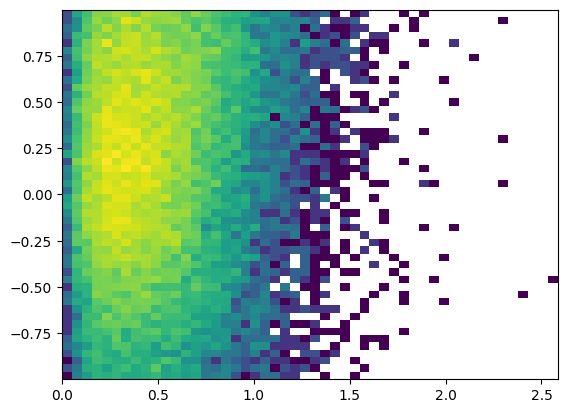

In [92]:
tmp = stack
tmp = tmp[tmp.confs<1]
tmp = tmp[tmp.confs>-1]
print(len(tmp))
lenscat(tmp)

In [87]:
truncuids = tmp.uid
truncuids.to_json("../trl-general/truncvals/rlcdbadhoriz.json", lines=True,  orient='records')

In [75]:
# files where I'm storing truncvals
fnames = ['wgboth', 'wgbadonly', 'rlcdbadonly', 'rlcdboth', 'apfboth', 'apfbadonly']

In [95]:
max(list(pd.read_json("../trl-general/truncvals/webgptboth.json", lines=True, orient='records')[0]))

17999

In [23]:
#companalysis(hard[hard.isrand==0], 25)

(array([[ 5.,  1.,  1., ...,  0.,  0.,  0.],
        [ 5., 25.,  8., ...,  0.,  0.,  0.],
        [ 0., 13., 20., ...,  0.,  0.,  0.],
        ...,
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]]),
 array([0.00917289, 0.02414239, 0.0391119 , 0.0540814 , 0.0690509 ,
        0.0840204 , 0.09898991, 0.11395941, 0.12892891, 0.14389842,
        0.15886792, 0.17383742, 0.18880693, 0.20377643, 0.21874593,
        0.23371544, 0.24868494, 0.26365444, 0.27862394, 0.29359345,
        0.30856295, 0.32353245, 0.33850196, 0.35347146, 0.36844096,
        0.38341047, 0.39837997, 0.41334947, 0.42831898, 0.44328848,
        0.45825798, 0.47322748, 0.48819699, 0.50316649, 0.51813599,
        0.5331055 , 0.548075  , 0.5630445 , 0.57801401, 0.59298351,
        0.60795301, 0.62292252, 0.63789202, 0.65286152, 0.66783103,
        0.68280053, 0.69777003, 0.71273953, 0.72770904, 0.74267854,
        0.75764804]),
 array([0.034

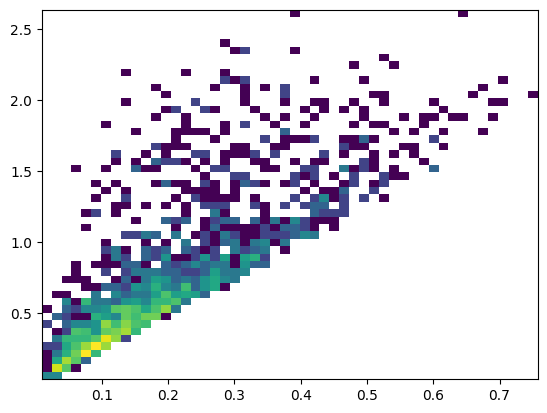

In [35]:
lenscat(ndf[ndf.confs>ndf.vars*2.5])

In [34]:
lenscat(hard)

NameError: name 'hard' is not defined

In [30]:
# when skipping first 
easy = ndf[ndf['confs']-4>(ndf['vars']*1.6)]
ambig = ndf[ndf['confs']-4<(ndf['vars']*1.6)]
hard = ambig[ambig['confs']-10<(ambig['vars']*-0.5)]
ambig = ambig[ambig['confs']-10>(ambig['vars']*-0.5)]
# when not skipping first
# easy = ndf[ndf['confs']-2.5>(ndf['vars']*1.6)]
# ambig = ndf[ndf['confs']-2.5<(ndf['vars']*1.6)]
# hard = ambig[ambig['confs']-10<(ambig['vars']*-2)]
# ambig = ambig[ambig['confs']-10>(ambig['vars']*-2)]

In [60]:
lenheur(hard)

0.5603349828701941

(array([15365.,  3494.,  1149.,   604.,   295.,   165.,   138.,   129.,
           68.,    17.]),
 array([4.84848673e-03, 7.03409866e-01, 1.40197124e+00, 2.10053262e+00,
        2.79909400e+00, 3.49765538e+00, 4.19621676e+00, 4.89477814e+00,
        5.59333952e+00, 6.29190090e+00, 6.99046228e+00]),
 <BarContainer object of 10 artists>)

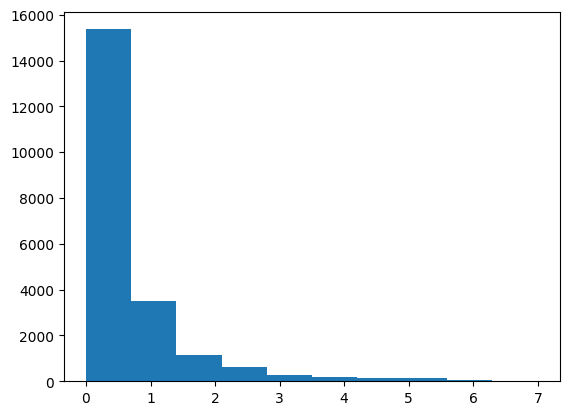

In [62]:
plt.hist(ndf['vars'])

In [42]:
hard.isrand.mean()

0.02941976181412801

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 1., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([0.01151005, 0.15108909, 0.29066814, 0.43024718, 0.56982623,
        0.70940527, 0.84898432, 0.98856336, 1.12814241, 1.26772145,
        1.4073005 , 1.54687954, 1.68645858, 1.82603763, 1.96561667,
        2.10519572, 2.24477476, 2.38435381, 2.52393285, 2.6635119 ,
        2.80309094, 2.94266999, 3.08224903, 3.22182807, 3.36140712,
        3.50098616, 3.64056521, 3.78014425, 3.9197233 , 4.05930234,
        4.19888139, 4.33846043, 4.47803948, 4.61761852, 4.75719756,
        4.89677661, 5.03635565, 5.1759347 , 5.31551374, 5.45509279,
        5.59467183, 5.73425088, 5.87382992, 6.01340897, 6.15298801,
        6.29256705, 6.4321461 , 6.57172514, 6.71130419, 6.85088323,
        6.99046228]),
 array([-6.44238281, -6.02400391, -5.605625  , -5

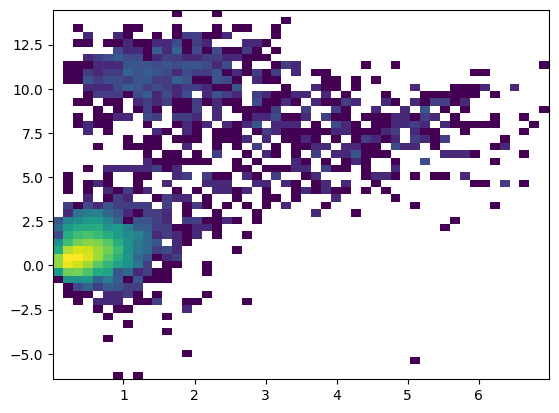

In [57]:
lenscat(ndf[(ndf.tj-ndf.tk)>40])

In [45]:
ndf.loc[0].rew_j

[1.609375,
 0.84765625,
 0.328125,
 -0.142578125,
 -0.1416015625,
 1.1484375,
 -0.404296875]

In [72]:
ind = 4
print(easy.iloc[ind]['rj'])
print("____")
print(easy.iloc[ind]['rk'])

One reason that pandas do not eat meat is that eating meat is not tasty for them [1,2,7]. Another reason that pandas eat bamboo instead of meat is because pandas have a high amount of bacteria in their gut, primarily due to the amount of fiber in bamboo. These bacteria help with the digestion of the bamboo [3,4,5,6,7,8,9,10,11,12]. Pandas can survive on a bamboo-based diet because of their gut flora and the presence of Clostridium bacteria, which have enzymes to break cellulose into simpler sugars [1,2,4,5,6,7,8,9,10,11]. With the help of these helpful bacteria and the help from the Clostridium, pandas can live as vegetarians [4,5,7,8,9,10,11,12]. This study provides evidence that pandas thrive on a diet of bamboo, and that their gut flora helps them digest this food source easily [1,2,3,4,6,7,8,9,10,11,12].
____
It is possible to maintain mental clarity until death of old age, as shown by the fact that some people do it [1, 2, 3]. The factors that determine whether or not a person wil

In [65]:
companalysis(hard, 20)

Top tokens with probabilities for 'good' class:
Ig: 0.8500
everybody: 0.8077
executes: 0.7619
uch: 0.7586
guests: 0.7568
Top tokens with probabilities for 'bad' class:
afterwards: 0.7727
Thanks: 0.7500
bundle: 0.7407
Kore: 0.7308
inclus: 0.7273


(array([[1., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 1., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([0.42570786, 0.5415985 , 0.65748915, 0.77337979, 0.88927043,
        1.00516107, 1.12105171, 1.23694236, 1.352833  , 1.46872364,
        1.58461428, 1.70050492, 1.81639557, 1.93228621, 2.04817685,
        2.16406749, 2.27995813, 2.39584878, 2.51173942, 2.62763006,
        2.7435207 , 2.85941134, 2.97530199, 3.09119263, 3.20708327,
        3.32297391, 3.43886455, 3.5547552 , 3.67064584, 3.78653648,
        3.90242712, 4.01831776, 4.13420841, 4.25009905, 4.36598969,
        4.48188033, 4.59777097, 4.71366162, 4.82955226, 4.9454429 ,
        5.06133354, 5.17722418, 5.29311483, 5.40900547, 5.52489611,
        5.64078675, 5.75667739, 5.87256804, 5.98845868, 6.10434932,
        6.22023996]),
 array([ 3.34654018,  3.56202148,  3.77750279,  3

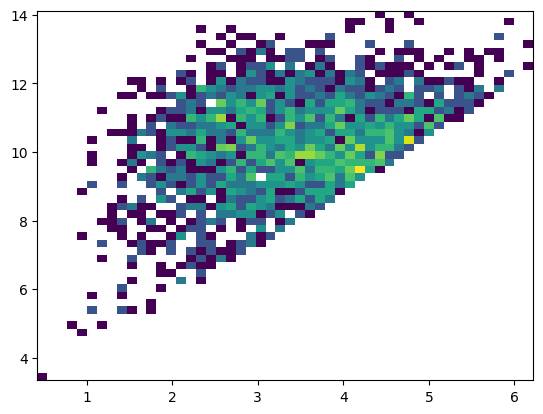

In [14]:
lenscat(easy)

In [61]:
lenheur(ambig)

0.5316091954022989

/tmp/ipykernel_216054/780445290.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  lenscat(hard[ndf['tj']>ndf['tk']])


(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([0.04345484, 0.15416041, 0.26486598, 0.37557155, 0.48627712,
        0.59698269, 0.70768826, 0.81839383, 0.9290994 , 1.03980497,
        1.15051054, 1.26121611, 1.37192168, 1.48262726, 1.59333283,
        1.7040384 , 1.81474397, 1.92544954, 2.03615511, 2.14686068,
        2.25756625, 2.36827182, 2.47897739, 2.58968296, 2.70038853,
        2.8110941 , 2.92179967, 3.03250524, 3.14321081, 3.25391639,
        3.36462196, 3.47532753, 3.5860331 , 3.69673867, 3.80744424,
        3.91814981, 4.02885538, 4.13956095, 4.25026652, 4.36097209,
        4.47167766, 4.58238323, 4.6930888 , 4.80379437, 4.91449995,
        5.02520552, 5.13591109, 5.24661666, 5.35732223, 5.4680278 ,
        5.57873337]),
 array([-5.58007812, -5.35446094, -5.12884375, -4

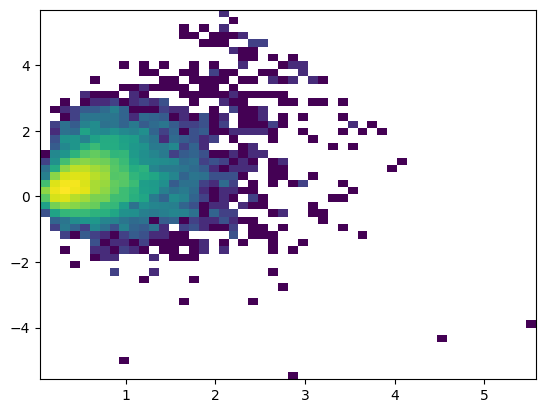

In [65]:
lenscat(hard[ndf['tj']>ndf['tk']])

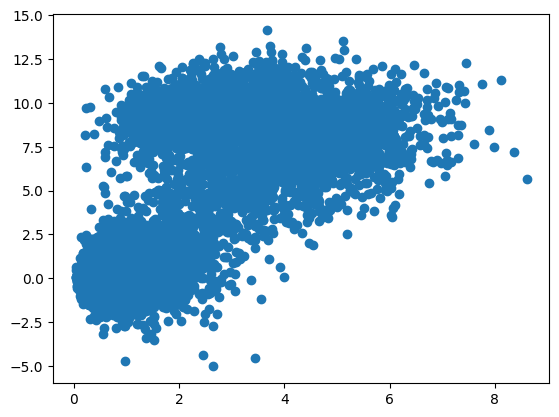

In [15]:
plt.scatter(ndf['vars'], ndf['confs'])

In [55]:
ndf = ndf.reset_index()

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([0.00983051, 0.17836438, 0.34689826, 0.51543213, 0.683966  ,
        0.85249987, 1.02103374, 1.18956761, 1.35810148, 1.52663535,
        1.69516922, 1.86370309, 2.03223696, 2.20077084, 2.36930471,
        2.53783858, 2.70637245, 2.87490632, 3.04344019, 3.21197406,
        3.38050793, 3.5490418 , 3.71757567, 3.88610954, 4.05464342,
        4.22317729, 4.39171116, 4.56024503, 4.7287789 , 4.89731277,
        5.06584664, 5.23438051, 5.40291438, 5.57144825, 5.73998212,
        5.908516  , 6.07704987, 6.24558374, 6.41411761, 6.58265148,
        6.75118535, 6.91971922, 7.08825309, 7.25678696, 7.42532083,
        7.5938547 , 7.76238858, 7.93092245, 8.09945632, 8.26799019,
        8.43652406]),
 array([-4.77109375, -4.41385938, -4.056625  , -3

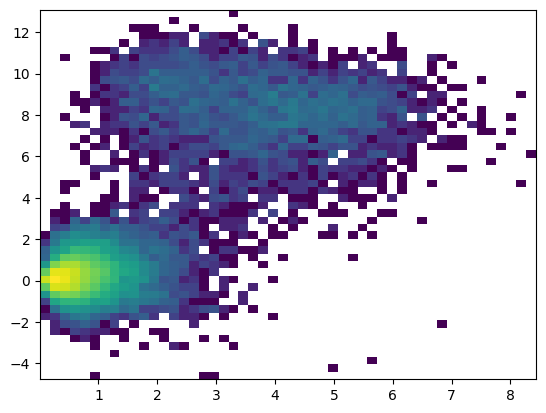

In [11]:
plt.hist2d(ndf['vars'], ndf['confs'], bins=(50, 50), norm=matplotlib.colors.LogNorm())